<a href="https://colab.research.google.com/github/LinusCrugnola/python/blob/main/DLAV_Project/DLAV_Phase1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DLAV Project - Phase 1

In this notebook we will train a very simple planner on data coming from a driving simulator. You are given a dash cam image of the current state of the driving vehicle, and the past positions of this vehicle, and you are asked to plan its future route.

This notebook will take you through steps on building this planner to solve the task. The full skeleton of the code together with some very simple implementations of each module are provided for your comfort. So all the cells below will run without you needing to change anything, but the performance won't be very good. You are asked to re-implement and play with most of the modules yourself to be able to have better performance.

P.S. to enable fast compute, you should use GPUs in google colab. The code works without GPUs, but it'll be much faster to use GPUs, specially if your model gets bigger and bigger! You can utilize Colab's GPUs by selecting "Change runtime type" in the Runtime menu on top of this page. There you can select "T4 GPU". This would restart your runtime, so you'll need to re-run everything from the top.

The first step is to prepare the data. The code below will download the data from google drive and extract it here for your code to use. Whenever your session gets restarted, remember to re-run this cell to re-download the data.

In [26]:
# Install gdown to handle Google Drive file download
!pip install -q gdown
!pip install -q safetensors

# Standard libs
import os
import zipfile
import pickle
import random
import heapq

# Third-party libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torchvision import transforms
import gdown
from scipy.signal import savgol_filter
from torchvision.transforms import v2

from safetensors import safe_open
from safetensors.torch import save_file, load_file

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [13]:
download_url = f"https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr"
output_zip = "dlav_train.zip"
gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu"
output_zip = "dlav_val.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV"
output_zip = "dlav_test_public.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

Downloading...
From (original): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr
From (redirected): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr&confirm=t&uuid=237117b3-5c30-4d4d-9fe9-958c86bc9962
To: /home/linus/prog/DLAV_Project_Ammann_Crugnola/dlav_train.zip
100%|██████████| 439M/439M [00:06<00:00, 72.6MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu
From (redirected): https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu&confirm=t&uuid=c1ad9ac6-3d32-474d-8101-e9a6d43d5177
To: /home/linus/prog/DLAV_Project_Ammann_Crugnola/dlav_val.zip
100%|██████████| 87.8M/87.8M [00:01<00:00, 66.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV
From (redirected): https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV&confirm=t&uuid=2a5ab77f-2a2e-44ff-a9e0-cbdea7b044ce
To: /home/linus/prog/DLAV_Project_Ammann_Crugnola/dlav_test_public.z

Now lets load the data and visualize the first few examples to see what we are dealing with!

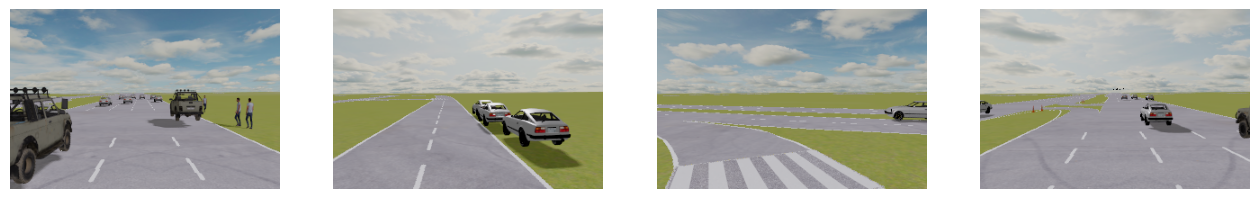

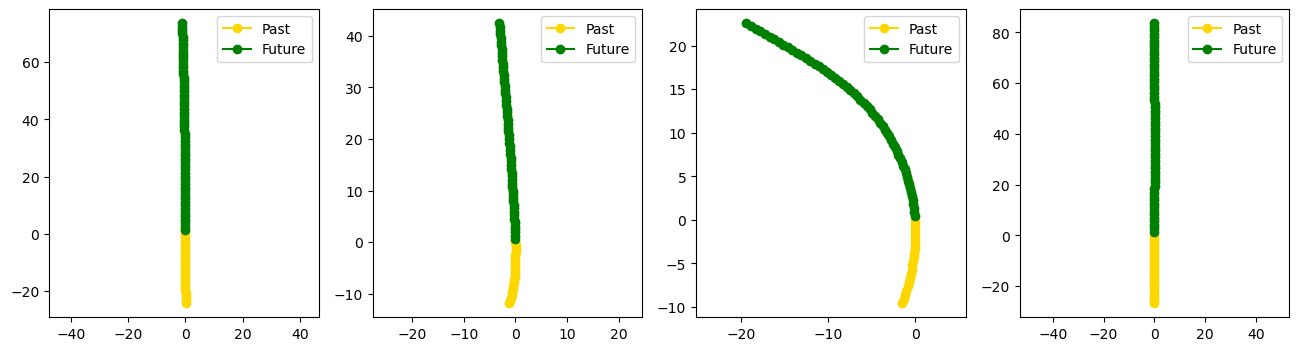

In [14]:
k = 4
# load the data
data = []
for i in random.choices(np.arange(1000), k=k):
    with open(f"train/{i}.pkl", "rb") as f:
        data.append(pickle.load(f))

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(data[i]["camera"])
    axis[i].axis("off")
plt.show()

def plot_trajectory(plt, trajectory):
    plt.plot(trajectory["sdc_history_feature"][:, 1]*-1, trajectory["sdc_history_feature"][:, 0], "o-", color="gold", label="Past")
    plt.plot(trajectory["sdc_future_feature"][:, 1]*-1, trajectory["sdc_future_feature"][:, 0], "o-", color="green", label="Future")
    plt.legend()
    plt.axis("equal")

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    plot_trajectory(axis[i], data[i])
plt.show()

Now its time to make our hands dirty!

In the following cells we will define the classes we need to do a proper training in pytorch.

1. We will start with defining a Dataset class which loads the data and does some basic preprocessing. You can further process this data as you see fit.
2. We then define the logger which receives training metrics and logs and prints/visualizes them. Having a good logger means a lot when dealing with neural network training! The logger implemented here is very simple and we strongly suggest you try other ways of visualizing your losses and metrics. Be creative ;)
3. We then proceed with defining the core part of the pipeline, the model. You are going to mainly implement the model yourself, but we have provided a very simple model so that the code runs as is so that you can see how the whole framework runs all in all.
4. Finally, we define the training funciton which contains the training loop, and we call it to see the magic! You'll need to also do a lot of changes here, from the batch size and learning rate, to adding augmentation schemes and schedulers, etc.

### Data Preprocessing

In [ ]:
import copy
import torch.nn.functional as F
from enum import Enum

def motion_augmentation(trajectory):
    ''' Augment the trajectory by calculating velocities and deltas '''
    aug = trajectory.copy()

    dx = np.diff(aug[:, 0], prepend=aug[0, 0])
    dy = np.diff(aug[:, 1], prepend=aug[0, 1])
    dtheta = np.diff(aug[:, 2], prepend=aug[0, 2])
    speed = np.sqrt(dx**2 + dy**2)

    return np.stack([aug[:, 0], aug[:, 1], aug[:, 2], dx, dy, dtheta, speed], axis=-1)

class TrajectoryClass(Enum):
    # FAR_STRAIGHT = 0
    # NEAR_STRAIGHT = 1
    # WIDE_TURN = 2
    # SHARP_TURN = 3
    # STATIONARY = 4
    STRAIGHT = 0
    CURVE = 1

def classify_trajectory(trajectory):
#     ''' Classify the trajectory into classes to get some statistics 
#     - Final point within += n_deg of the start point -> straight
#     - Further than far_thresh -> far / wide turn
#     '''
#     # N_DEG = 3
#     FAR_THRESH_STRAIGHT = 35
#     FAR_THRESH_TURN = 22
#     STATIONARY_THRESH = 0.1
#     TURN_HEAD_THRESH = 0.1
#     # FAC = np.tan(np.deg2rad(N_DEG))

    x_f, y_f, h_f = trajectory[-1, :3]

    if abs(y_f) > 5:
        return TrajectoryClass.CURVE
    else:
        return TrajectoryClass.STRAIGHT

#     if np.linalg.norm([x_f, y_f]) < STATIONARY_THRESH:
#         return TrajectoryClass.STATIONARY

#     # y_dev_thresh = x_f * FAC
#     if abs(h_f) > TURN_HEAD_THRESH:
#         # turn
#         if x_f > FAR_THRESH_TURN:
#             return TrajectoryClass.WIDE_TURN
#         else:
#             return TrajectoryClass.SHARP_TURN
        
#     else:
#         # straight
#         if x_f > FAR_THRESH_STRAIGHT:
#             return TrajectoryClass.FAR_STRAIGHT
#         else:
#             return TrajectoryClass.NEAR_STRAIGHT




def preprocess_and_save(file_list, output_dir, normalize=True, flip=True, motion_mean=None, motion_std=None, delete_original=True):
    print(f"Preprocessing {len(file_list)} files in folder {os.path.dirname(file_list[0])}...")

    # Check if all expected files are already present
    if os.path.exists(output_dir) and len(os.listdir(output_dir)) >= 10000:
        print(f"Output directory '{output_dir}' already contains all files, skipping preprocessing...")
        return

    os.makedirs(output_dir, exist_ok=True)

    # Step 1: Get motion data mean and std to normalize
    def get_motion_stats(file_list):

        all_feats = []

        for file in file_list:
            with open(file, 'rb') as f:
                data = pickle.load(f)

                # augment the trajectory
                history_aug = motion_augmentation(data['sdc_history_feature'])
                all_feats.append(history_aug)

        all_feats = np.concatenate(all_feats, axis=0)

        return all_feats.mean(axis=0), all_feats.std(axis=0)

    if motion_mean is None or motion_std is None:
        motion_mean, motion_std = get_motion_stats(file_list)
    new_file_list = []

    command_map = {'left': 0, 'right': 1, 'forward': 2}

    # Step 2: preprocess the data and save to pytorch format
    trajectory_classes = []

    for file in file_list:

        # new file names with .safetensors extension and f is flipped
        normal_file = os.path.join(output_dir, os.path.basename(file).replace('.pkl', '.safetensors'))
        if flip:
            flip_file = os.path.join(output_dir, 'f' + os.path.basename(file).replace('.pkl', '.safetensors'))

        with open(file, 'rb') as f:
            data = pickle.load(f)

        # get trajectory class
        if 'sdc_future_feature' in data:
            trajectory_classes.append(classify_trajectory(data['sdc_future_feature']))
            if flip:
                trajectory_classes.append(classify_trajectory(data['sdc_future_feature']))

        if flip:
            data_flip = copy.deepcopy(data)
            # flip the y axis and heading of past and future trajectory
            data_flip['sdc_history_feature'][:, 1:] *= -1
            if 'sdc_future_feature' in data_flip:
                data_flip['sdc_future_feature'][:, 1:] *= -1

            # flip the camera image (width channel)
            data_flip['camera'] = data_flip['camera'][:, ::-1, :].copy()
            data_flip['depth'] = data_flip['depth'][:, ::-1, :].copy()
            data_flip['semantic_label'] = data_flip['semantic_label'][:, ::-1].copy()

        def normalize_and_save(data, motion_mean, motion_std, file_name):
            # normalize & augment motion, don't normalize future trajectory
            history_aug = motion_augmentation(data['sdc_history_feature'])
            history_aug = (history_aug - motion_mean) / motion_std

            # create tensors and normalize camera data with imagenet mean and std
            imgnet_mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            imgnet_std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

            camera = torch.FloatTensor(data['camera'])
            camera = camera.permute(2, 0, 1) / 255.0
            camera = (camera - imgnet_mean) / imgnet_std
            camera = camera.contiguous()

            # preprocess tensors and save
            sample = {
                'camera': camera,
                'history': torch.FloatTensor(history_aug),
                'depth': torch.FloatTensor(data['depth']),
                'semantic': torch.FloatTensor(data['semantic_label']),
            }

            sample['command'] = F.one_hot(torch.tensor(command_map[data['driving_command']]), num_classes=3).float()
            
            if 'sdc_future_feature' in data:
                sample['future'] = torch.FloatTensor(data['sdc_future_feature'])

            save_file(sample, file_name)

        normalize_and_save(data, motion_mean, motion_std, normal_file)
        new_file_list.append(normal_file)
        if flip:
            normalize_and_save(data_flip, motion_mean, motion_std, flip_file)
            new_file_list.append(flip_file)

    print(f"Preprocessed {len(new_file_list)} files in folder {output_dir}...")

    # delete original folder with all the pkl files
    if delete_original:
        print(f"Deleting original files in {os.path.dirname(file_list[0])}...")
        for file in file_list:
            os.remove(file)
        os.rmdir(os.path.dirname(file_list[0]))

    return motion_mean, motion_std, new_file_list, trajectory_classes

def denormalize_image(image):
    ''' Give the torch tensor and get a original image '''
    imgnet_mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    imgnet_std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = image * imgnet_std + imgnet_mean
    image = image.permute(1, 2, 0)
    image = image * 255.0
    return image.byte().numpy()

def denormalize_motion(motion, motion_mean, motion_std):
    ''' Give the torch tensor and get a original motion '''
    nb_feat = motion.shape[1]
    denorm = motion * motion_std[:nb_feat] + motion_mean[:nb_feat]

    if type(denorm) == np.ndarray:
        return denorm
    return denorm.numpy()

# Preprocess and save the train and val data
train_files = [os.path.join("train", f) for f in os.listdir("train") if f.endswith(".pkl")]
val_files = [os.path.join("val", f) for f in os.listdir("val") if f.endswith(".pkl")]

train_mean, train_std, train_files, train_traj_classes = preprocess_and_save(train_files, "train_preprocessed", flip=True, delete_original=False)

Preprocessing 5000 files in folder train...
Preprocessed 10000 files in folder train_preprocessed...


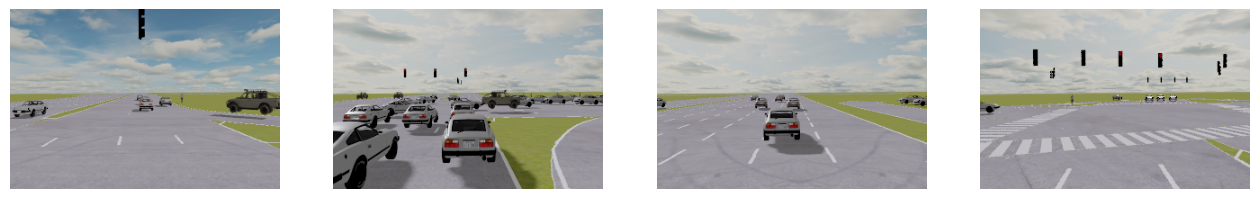

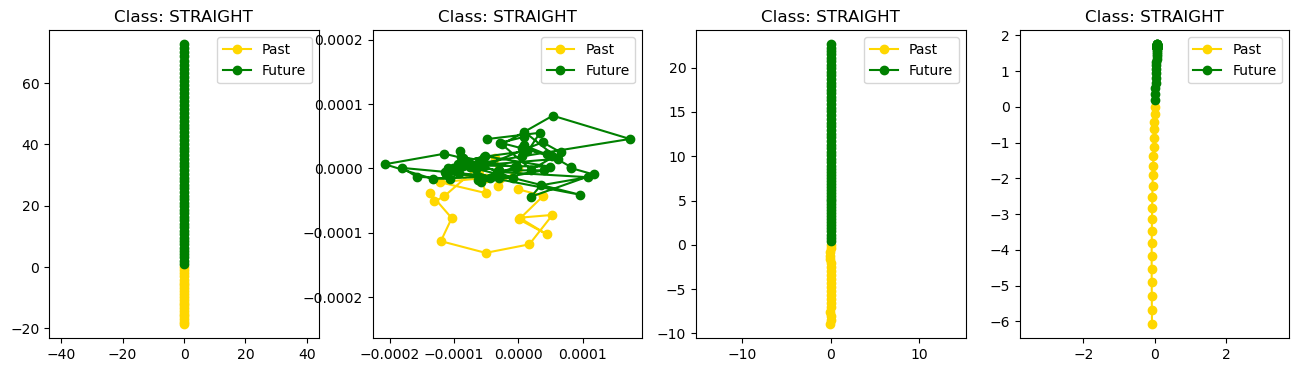

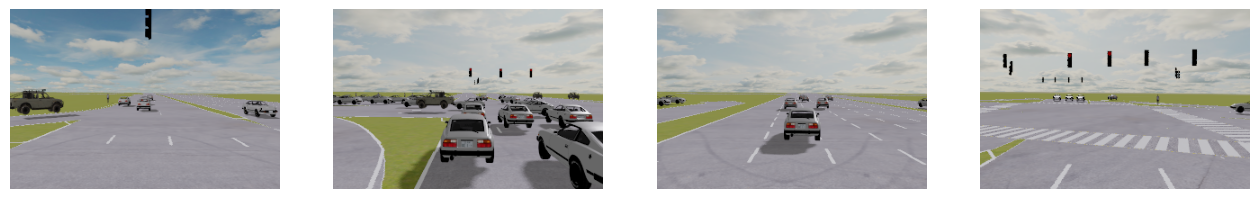

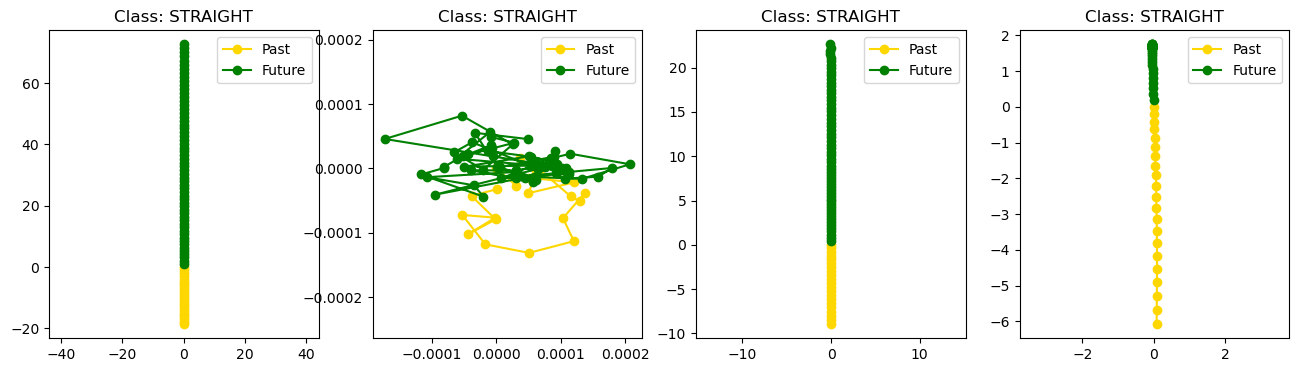

In [ ]:
# plot some samples and check if flip works
k = 4
# load the data
data = []
data_flip = []
for i in random.choices(np.arange(1000), k=k):
    data.append(load_file(f"train_preprocessed/{i}.safetensors"))

    data_flip.append(load_file(f"train_preprocessed/f{i}.safetensors"))

# plot the camera view of current step for the k examples
for d in [data, data_flip]:
    fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
    for i in range(k):
        axis[i].imshow(denormalize_image(d[i]["camera"]))
        axis[i].axis("off")
    plt.show()

    def plot_trajectory(plt, trajectory):
        hist = denormalize_motion(trajectory["history"], train_mean, train_std)
        plt.plot(hist[:, 1]*-1, hist[:, 0], "o-", color="gold", label="Past")
        plt.plot(trajectory["future"][:, 1]*-1, trajectory["future"][:, 0], "o-", color="green", label="Future")
        plt.legend()
        plt.axis("equal")
        plt.set_title(f"Class: {classify_trajectory(trajectory['future']).name}")

    # plot the past and future trajectory of the vehicle
    fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
    for i in range(k):
        plot_trajectory(axis[i], d[i])
    plt.show()

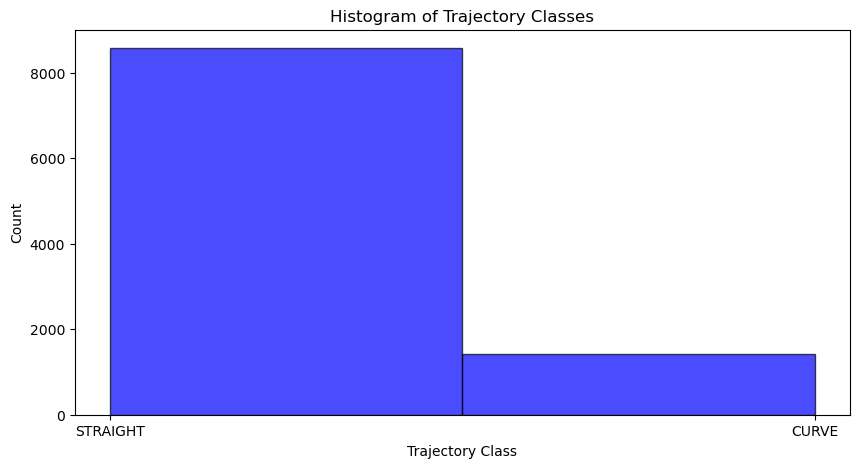

[8578 1422]


In [18]:
# plot histogram of trajectory classes
plt.figure(figsize=(10, 5))
plt.hist([traj_class.value for traj_class in train_traj_classes], bins=2, color='blue', alpha=0.7, edgecolor='black')
plt.xticks(range(2), [traj_class.name for traj_class in TrajectoryClass])
plt.xlabel('Trajectory Class')
plt.ylabel('Count')
plt.title('Histogram of Trajectory Classes')
plt.show()

# print counts
print(np.bincount([traj_class.value for traj_class in train_traj_classes]))

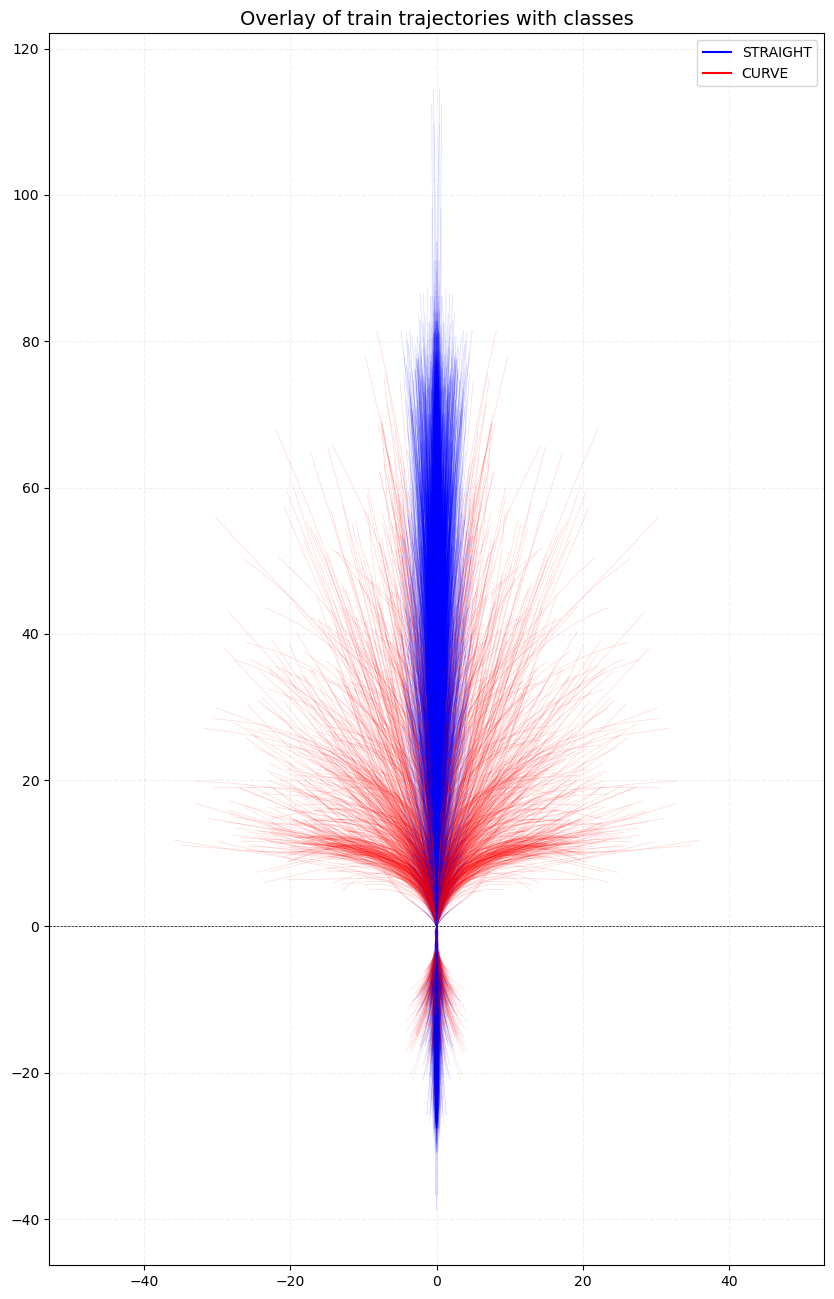

In [ ]:
# Plot overlay of all samples with class color

color_map = {
    # TrajectoryClass.FAR_STRAIGHT: "blue",
    # TrajectoryClass.NEAR_STRAIGHT: "green",
    # TrajectoryClass.WIDE_TURN: "orange",
    # TrajectoryClass.SHARP_TURN: "red",
    # TrajectoryClass.STATIONARY: "purple"
    TrajectoryClass.STRAIGHT: "blue",
    TrajectoryClass.CURVE: "red"
}

plt.figure(figsize=(10, 16))

plt.title("Overlay of train trajectories with classes", fontsize=14)
plt.axis("equal")
plt.grid(True, linestyle="--", alpha=0.2)

for j, file in enumerate(train_files):
    data = load_file(file)
    hist = denormalize_motion(data["history"], train_mean, train_std)  # Denormalize
    hist = hist[:, :2] # Extract x, y coordinates
    fut = data["future"][:, :2]  # Extract x, y coordinates

    # color based on class
    color = color_map[train_traj_classes[j]]

    plt.plot(hist[:, 1] * -1, hist[:, 0], color=color, linewidth=0.5, alpha=0.1)
    plt.plot(fut[:, 1] * -1, fut[:, 0], color=color, linewidth=0.5, alpha=0.15)


plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
for traj_class, color in color_map.items():
    plt.plot([], [], color=color, label=traj_class.name)
plt.legend()

plt.savefig("class_heatmap.png", dpi=500)
plt.show()

In [ ]:
class DrivingDataset(Dataset):
    def __init__(self, file_list, class_list=None, test=False, transform=None):
        self.samples = file_list
        self._labels = [cls.value for cls in class_list] if class_list else None
        self.test = test

        # base_transforms = [
        #     v2.ToDtype(torch.float32, scale=True),
        #     v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # ]

        # if transform is not None and not test:
        #     self.transform = transforms.Compose(transform.transforms + base_transforms)
        # else:
        #     self.transform = transforms.Compose(base_transforms)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        data = load_file(self.samples[idx])
        # data["camera"] = self.transform(data["camera"])
        return data

    def get_labels(self):
        if self._labels is None:
            raise ValueError("Labels are not available for this dataset.")
        return self._labels


In [20]:
from torch.utils.data import DataLoader, WeightedRandomSampler

def get_balanced_loader(dataset, batch_size=64, balance_strength=1.0):
    """
    balance_strength: float in [0.0, 1.0]
        0.0 -> natural sampling (no balance)
        1.0 -> fully balanced across classes
    """
    labels = np.array(dataset.get_labels())
    class_counts = np.bincount(labels)
    total = float(len(labels))

    # Inverse frequency
    class_weights = total / (len(class_counts) * class_counts)

    # Blend between uniform and natural freq
    freq_weights = np.array([class_weights[label] for label in labels])
    uniform_weights = np.ones_like(freq_weights)

    # Mix
    weights = (1 - balance_strength) * uniform_weights + balance_strength * freq_weights
    weights = torch.DoubleTensor(weights)

    sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

    return DataLoader(dataset, batch_size=batch_size, sampler=sampler, num_workers=4)


In [21]:
class Logger:
    def __init__(self):
        self.metrics = {"train_loss": [], "val_loss": [], "val_ade": [], "val_fde": []}

    def log(self, step=None, **metrics):
        """
        Logs the given metrics.

        Args:
            step (int, optional): The current step or epoch. Useful for tracking.
            **metrics: Arbitrary keyword arguments representing metric names and values.
        """
        prefix = f"[Step {step}] " if step is not None else ""
        metric_str = " | ".join(f"{k}: {v}" for k, v in metrics.items())
        #print(prefix + metric_str)

        # Store metrics
        for key, value in metrics.items():
            if key in self.metrics:
                self.metrics[key].append(value)

    def plot(self):
        """
        Plots the logged metrics.
        """
        epochs = range(1, len(self.metrics["train_loss"]) + 1)

        plt.figure(figsize=(12, 6))

        # Plot training and validation loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.metrics["train_loss"], label="Train Loss", marker="o")
        plt.plot(epochs, self.metrics["val_loss"], label="Val Loss", marker="o")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()

        # Plot ADE and FDE
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.metrics["val_ade"], label="Val ADE", marker="o")
        plt.plot(epochs, self.metrics["val_fde"], label="Val FDE", marker="o")
        plt.xlabel("Epoch")
        plt.ylabel("Distance")
        plt.title("Validation ADE and FDE")
        plt.legend()

        plt.tight_layout()
        plt.show()

In [22]:
class DrivingPlanner(nn.Module):
    def __init__(self):
        super().__init__()
        # Load ResNet-18 and remove avgpool + fc
        resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.image_encoder = nn.Sequential(*list(resnet.children())[:-2])  # Keep conv layers only

        # Project the final feature map to 128D vector using global pooling + linear
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # Fully convolutional safe pooling
        self.img_proj = nn.Linear(512, 128)

        # Motion encoder
        self.motion_encoder_lstm = nn.LSTM(7, 64, 2, batch_first=True)

        self.decoder = nn.Sequential(
            nn.Linear(128 + 64, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 2*60)  # 60 steps x 2 coords
        )

    def forward(self, camera, history):

        B = camera.size(0)

        feat_map = self.image_encoder(camera)

        pooled = self.global_pool(feat_map).view(B, -1)  # Shape: (B, 512)
        img_feat = self.img_proj(pooled)

        motion_feat, _ = self.motion_encoder_lstm(history)
        motion_feat = motion_feat[:, -1, :]

        x = torch.cat([img_feat, motion_feat], dim=1)
        out = self.decoder(x)
        return out.view(-1, 60, 2)

    def smooth_trajectory(self, trajectory, window_size=3):
      x_smooth = savgol_filter(trajectory[:, 0], window_length=9, polyorder=3)
      y_smooth = savgol_filter(trajectory[:, 1], window_length=9, polyorder=3)

      predicted_smoothed = np.stack([x_smooth, y_smooth],axis=1)
      return predicted_smoothed

    def predict(self, camera, history, window_size=3):
        # Perform forward pass to get predictions
        with torch.no_grad():
          pred_future = self.forward(camera, history).cpu().numpy()  # Shape: (B, T, 2)

        # Apply smoothing to each trajectory
        smoothed_pred_future = np.array([self.smooth_trajectory(pred, window_size) for pred in pred_future])

        # Convert back to torch.Tensor
        return torch.tensor(smoothed_pred_future, dtype=torch.float32)

In [23]:
def train(model, train_loader, val_loader, optimizer, logger, scheduler, num_epochs=50, phase1_epochs=15):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.MSELoss()

    # Phase 1: Freeze image encoder
    for param in model.image_encoder.parameters():
        param.requires_grad = False

    best_val_ade = float('inf')
    best_val_ade_model = None

    for epoch in range(num_epochs):
        # Training
        model.train()
        if epoch == phase1_epochs:
            print("Unfreezing image encoder for fine-tuning...")
            for param in model.image_encoder.parameters():
                param.requires_grad = True

        train_loss = 0
        for idx, batch in enumerate(train_loader):
            camera = batch['camera'].to(device)
            history = batch['history'].to(device)
            future = batch['future'].to(device)

            optimizer.zero_grad()
            pred_future = model(camera, history)
            loss = criterion(pred_future[..., :2], future[..., :2])
            loss.backward()
            optimizer.step()

            if idx % 10 == 0:
                logger.log(step=epoch * len(train_loader) + idx, loss=loss.item())
            train_loss += loss.item()

        scheduler.step()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss, ade_all, fde_all = 0, [], []
        with torch.no_grad():
            for batch in val_loader:
                camera = batch['camera'].to(device)
                history = batch['history'].to(device)
                future = batch['future'].to(device)

                pred_future = model(camera, history)
                loss = criterion(pred_future, future[:, :, :2])
                ADE = torch.norm(pred_future[:, :, :2] - future[:, :, :2], p=2, dim=-1).mean()
                FDE = torch.norm(pred_future[:, -1, :2] - future[:, -1, :2], p=2, dim=-1).mean()
                ade_all.append(ADE.item())
                fde_all.append(FDE.item())
                val_loss += loss.item()

            val_loss /= len(val_loader)
            val_ade = np.mean(ade_all)
            val_fde = np.mean(fde_all)

            if val_ade < best_val_ade:
                best_val_ade = val_ade
                best_val_ade_model = model.state_dict().copy()

        # Log metrics for the epoch
        logger.log(
            epoch=epoch + 1,
            train_loss=train_loss,
            val_loss=val_loss,
            val_ade=val_ade,
            val_fde=val_fde
        )

        print(f'''Epoch {epoch+1}/{num_epochs}\t | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val ADE: {val_ade:.4f} | Val FDE: {val_fde:.4f}''')

    return best_val_ade_model

In [24]:
# Some Visualization and helper functions

def plot_extreme_cases(model, val_loader, traj_mean, traj_std, num_cases=10, mode="worst"):
    assert mode in {"worst", "best"}, "mode must be 'worst' or 'best'"

    command_map_reverse = {0: 'left', 1: 'right', 2: 'forward'}

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    cases = []
    compare_fn = heapq.heappush if len(cases) < num_cases else heapq.heappushpop

    with torch.no_grad():
        for batch in val_loader:
            camera = batch['camera'].to(device)
            history = batch['history'].to(device)
            future = batch['future'].to(device)
            command = batch['command']
            if command_map_reverse[command.numpy().argmax().item()] != "forward":
                print(f"Command is {command_map_reverse[command.numpy().argmax().item()]}")

            pred_future = model(camera, history)
            ade_batch = torch.norm(pred_future[..., :2] - future[..., :2], dim=-1).mean(dim=-1).cpu().numpy()

            for i, ade in enumerate(ade_batch):
                score = ade if mode == "worst" else -ade
                item = (score, (camera[i].cpu(), history[i].cpu(), future[i].cpu(), pred_future[i].cpu(), command[i]))
                if len(cases) < num_cases:
                    heapq.heappush(cases, item)
                else:
                    heapq.heappushpop(cases, item)

    # Sort for display
    cases = sorted(cases, key=lambda x: -x[0] if mode == "worst" else x[0])

    # Plot
    fig, axes = plt.subplots(num_cases, 3, figsize=(15, 5 * num_cases))
    if num_cases == 1:
        axes = axes[np.newaxis, :]  # Handle single-row case

    for i, (score, (camera, history, future, pred_future, command)) in enumerate(cases):
        ade = score if mode == "worst" else -score
        denorm_img = denormalize_image(camera)

        axes[i, 0].imshow(denorm_img)
        axes[i, 0].axis('off')
        cmd = command_map_reverse[command.numpy().argmax().item()]
        axes[i, 0].set_title(f"ADE: {ade:.4f}\n cmd: {cmd}")

        history = history * traj_std + traj_mean
        axes[i, 1].plot(-history[:, 1], history[:, 0], 'o-', color='gold', label='Past')
        axes[i, 1].plot(-future[:, 1], future[:, 0], 'o-', color='green', label='Future')
        axes[i, 1].legend()
        axes[i, 1].axis('equal')
        axes[i, 1].set_title("Past & Future")

        axes[i, 2].plot(-history[:, 1], history[:, 0], 'o-', color='gold', label='Past')
        axes[i, 2].plot(-future[:, 1], future[:, 0], 'o-', color='green', label='Future')
        axes[i, 2].plot(-pred_future[:, 1], pred_future[:, 0], 'o-', color='red', label='Predicted', alpha=0.5)
        axes[i, 2].legend()
        axes[i, 2].axis('equal')
        axes[i, 2].set_title("Past, Future & Predicted")

    plt.tight_layout()
    plt.show()

def check_motion_normalization(dataset):
    all_feats = []

    for i in range(len(dataset)):
        sample = dataset[i]
        motion = sample['history']  # shape: (T, 7), normalized

        all_feats.append(motion.numpy())

    all_feats = np.concatenate(all_feats, axis=0)  # shape: (N × T, 7)

    mean = all_feats.mean(axis=0)
    std = all_feats.std(axis=0)

    with np.printoptions(precision=3, suppress=True):
        print("Normalized motion feature mean:", mean)
        print("Normalized motion feature std:", std)

def visualize_dataset_samples(dataset, traj_mean, traj_std, num_samples=4):
    indices = random.sample(range(len(dataset)), num_samples)

    fig, axs = plt.subplots(4, num_samples, figsize=(4 * num_samples, 15))  # Adjusted for 5 rows

    for i, idx in enumerate(indices):
        sample = dataset[idx]

        camera = sample['camera']
        history = sample['history'].numpy()
        future = sample['future'].numpy()

        # Denormalize image
        image = denormalize_image(camera)

        # Unnormalize history (augmented data)
        history = history * traj_std + traj_mean

        # Plot camera image (top row)
        axs[0, i].imshow(image)
        axs[0, i].axis('off')
        axs[0, i].set_title(f"Sample {idx}")

        # Plot trajectory (2nd row)
        axs[1, i].plot(-history[:, 1], history[:, 0], 'o-', label='Past (Augmented)', color='gold')
        axs[1, i].plot(-future[:, 1], future[:, 0], 'o-', label='Future (Original)', color='green')
        axs[1, i].legend()
        axs[1, i].axis('equal')
        axs[1, i].set_xlabel("Lateral (m)")
        axs[1, i].set_ylabel("Forward (m)")

        # Plot heading angle (3rd row)
        heading_history = history[:, 2]
        heading_future = future[:, 2]
        history_idx = range(len(heading_history)) - np.ones(len(heading_history))*len(heading_history) 
        axs[2, i].plot(history_idx, heading_history, marker='o', label='Past (Augmented)', color='blue')
        axs[2, i].plot(range(len(heading_future)), heading_future, marker='o', label='Future (Original)', color='cyan')
        axs[2, i].set_title("Heading angle (rad)")
        axs[2, i].set_xlabel("Timestep")
        axs[2, i].set_ylabel("θ")
        axs[2, i].legend()

        # Plot velocity (4th row)
        velocity_history = history[:, 6]
        axs[3, i].plot(range(len(velocity_history)), velocity_history, marker='o', label='Past (Augmented)', color='purple')
        axs[3, i].set_title("Velocity (m/s)")
        axs[3, i].set_xlabel("Timestep")
        axs[3, i].set_ylabel("Velocity")
        axs[3, i].legend()

    plt.tight_layout()
    plt.show()

# Trajectory heatmap
def plot_trajectory_overlay(ax, loader, title, train_mean, train_std, plot_future=True, prediction=None):
    """
    Plots trajectories from a PyTorch DataLoader.

    Args:
        loader (DataLoader): PyTorch DataLoader containing the dataset.
        title (str): Title of the plot.
        train_mean (np.array): Mean of the motion features for denormalization.
        train_std (np.array): Standard deviation of the motion features for denormalization.
        plot_future (bool): Whether to plot future trajectories.
        prediction (torch.Tensor or None): Predicted trajectories to overlay, if available.
    """
    ax.set_title(title, fontsize=14)
    ax.axis("equal")
    ax.grid(True, linestyle="--", alpha=0.2)

    for j, batch in enumerate(loader):
        history = batch["history"].numpy()  # Past trajectory
        future = batch["future"].numpy()  # Future trajectory
        for i in range(batch["history"].shape[0]):
            hist = denormalize_motion(history[i], train_mean, train_std)  # Denormalize
            hist = hist[:, :2] # Extract x, y coordinates

            fut = future[i]

            ax.plot(hist[:, 1] * -1, hist[:, 0], color="darkgreen", linewidth=0.5, alpha=0.1)
            if plot_future:
                ax.plot(fut[:, 1] * -1, fut[:, 0], color="darkblue", linewidth=0.5, alpha=0.15)

    if prediction is not None:
        for pred in prediction:
            for i in range(pred.shape[0]):
                pred_sample = pred[i]
                ax.plot(pred_sample[:, 1]*-1, pred_sample[:, 0], color='red', linewidth=0.5, alpha=0.15)

    ax.scatter(0, 0, color="black", s=20, marker="x", label="Ego start")
    ax.legend()

In [ ]:
# Load the training data
val_data_dir = "val"

val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]

# Preprocess and save the data
_, _, val_files, val_traj_classes = preprocess_and_save(val_files, "val_preprocessed", normalize=True, flip=False, motion_mean=train_mean, motion_std=train_std)

# transform = v2.Compose([
#     # v2.RandomApply([v2.GaussianBlur(kernel_size=3)], p=0.2),
#     v2.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0.05),
#     v2.RandomAffine(degrees=0, translate=(0.02, 0.02), scale=(0.95, 1.05), shear=2),
#     # v2.RandomAdjustSharpness(sharpness_factor=2, p=0.2),
# ])

train_dataset = DrivingDataset(train_files, train_traj_classes, test=False)#, transform=transform)
val_dataset   = DrivingDataset(val_files, val_traj_classes, test=False)

# Check motion feaures normalization
print("Check normalization for train data:")
check_motion_normalization(train_dataset)
print("Check normalization for validation data:")
check_motion_normalization(val_dataset)


Check normalization for train data:


KeyboardInterrupt: 

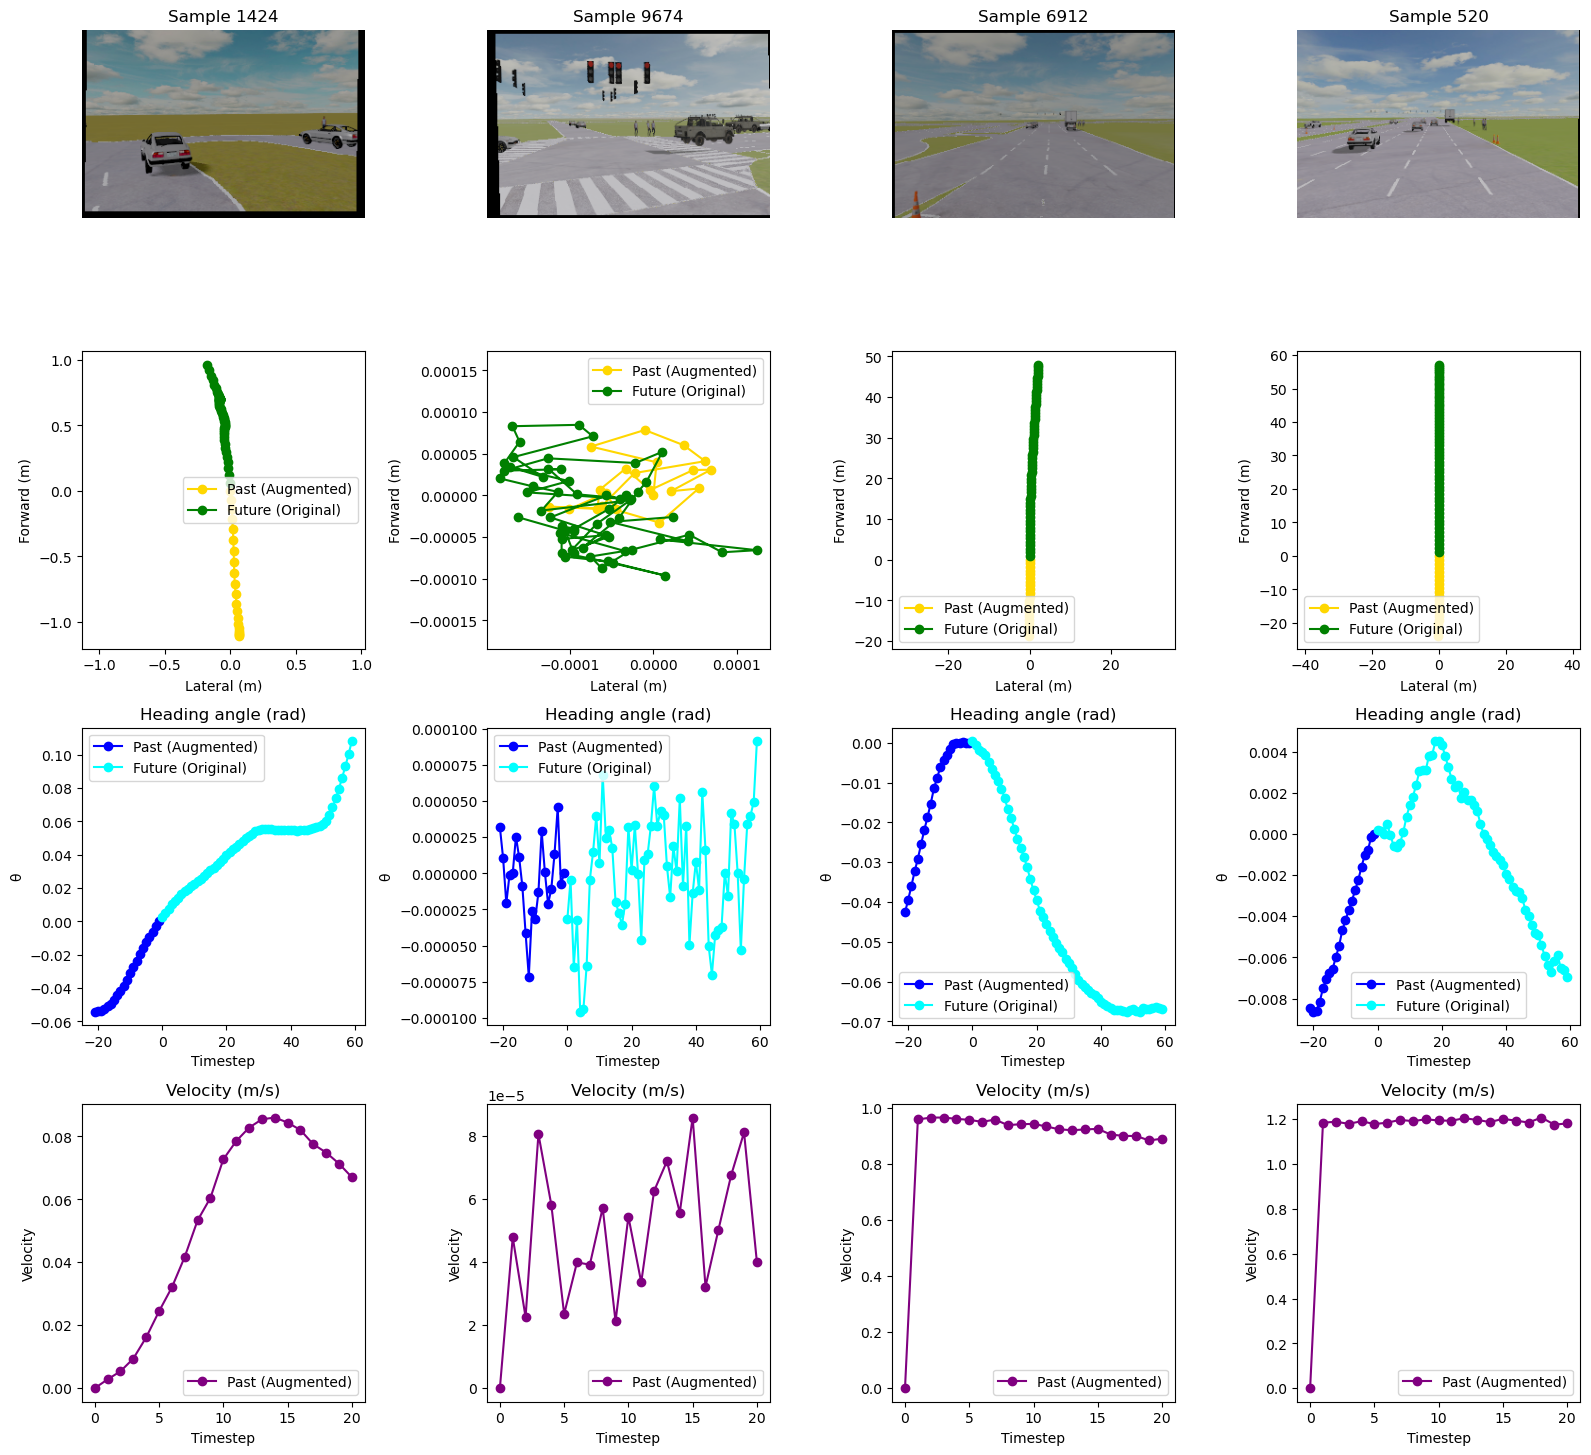

In [ ]:
# Create data loaders
train_loader = get_balanced_loader(train_dataset, batch_size=64, balance_strength=0.3)
# train_loader = DataLoader(train_dataset, batch_size=64, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=4)

# Plot a few samples to verify augmentation
visualize_dataset_samples(train_dataset, train_mean, train_std, num_samples=4)

In [ ]:
# Add model and define learning parameters
model = DrivingPlanner()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=7e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

logger = Logger()

# Train the model
best_model = train(model, train_loader, val_loader, optimizer, logger, scheduler, num_epochs=30, phase1_epochs=10)

logger.plot()

By running the code above, you have trained your first model!
What do you observe in terms of train and val losses? What is this phenomenon called? (Explain in a few lines below)




This model is very simple and does not necessarilly yield the optimal performance. You are asked to implement your own neural network architecture. You can use convolution networks, vision transformers, etc. Try with different architectures, different model sizes, and other hyper parameters such as learning rate and batch size to find the best performance. Other ideas could be to use augmentation thechniques to boost the performance, adding learning rate schedulers, and exploring other loss functions.

Once you are happy with your model, continue with the rest of the notebook to save your checkpoint and also visualize some plans coming from the model. The last cell will provide a `submission_phase1.csv` which you can submit to the leaderboard to see your results on the testing set.

In [ ]:
# save the models
torch.save(best_model, "phase1_best_model.pth")
torch.save(model.state_dict(), "phase1_last_model.pth")

In [ ]:
val_batch_zero = next(iter(val_loader))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
camera = val_batch_zero['camera'].to(device)
history = val_batch_zero['history'].to(device)
future = val_batch_zero['future'].to(device)

# reload models
model = DrivingPlanner().to(device)
model.load_state_dict(torch.load('phase1_best_model.pth', weights_only=True, map_location=device))

model.eval()
with torch.no_grad():
    pred_future = model(camera, history)
    pred_future_smoothed = model.predict(camera, history)

camera = camera.cpu()
history = history.cpu().numpy()
future = future.cpu().numpy()
pred_future = pred_future.cpu().numpy()
pred_future_smoothed = pred_future_smoothed.cpu().numpy()
k = 4
selected_indices = random.choices(np.arange(len(camera)), k=k)

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    denormalized_image = denormalize_image(camera[idx])
    axis[i].imshow(denormalized_image)
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    history[idx] = history[idx] * train_std + train_mean
    axis[i].plot(history[idx, :, 1]*-1, history[idx, :, 0], "o-", color="gold", label="Past")
    axis[i].plot(future[idx, :, 1]*-1, future[idx, :, 0], "o-", color="green", label="Future")
    axis[i].plot(pred_future[idx, :, 1]*-1, pred_future[idx, :, 0], "o-", color="red", label="Predicted", alpha=0.5)
    axis[i].plot(pred_future_smoothed[idx, :, 1]*-1, pred_future_smoothed[idx, :, 0], "o-", color="blue", label="Smoothed", alpha=0.5)
    axis[i].legend()
    axis[i].axis("equal")
plt.show()  

In [ ]:
# Display the worst cases in terms of ADE
plot_extreme_cases(model, val_loader, train_mean, train_std, num_cases=40, mode="worst")

In [ ]:
# Display the best cases in terms of ADE
plot_extreme_cases(model, val_loader, train_mean, train_std, num_cases=20, mode="best")

In [ ]:
# Get all the validation predictions and plot the overlay map

all_preds = []
all_preds_smothed = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)
        future = batch['future'].to(device)

        pred_future = model(camera, history)
        pred_future_smoothed = model.predict(camera, history)
        all_preds.append(pred_future.cpu().numpy())
        all_preds_smothed.append(pred_future_smoothed.cpu().numpy())

fig, axes = plt.subplots(1, 3, figsize=(16, 8))

# plot_trajectory_overlay(axes[0], train_loader, "Train Set Trajectory Heatmap", train_mean, train_std)
plot_trajectory_overlay(axes[0], val_loader, "Validation Set Trajectory Heatmap", train_mean, train_std)
plot_trajectory_overlay(axes[1], val_loader, "Validation Set Prediction Heatmap", train_mean, train_std,
                        plot_future=False, prediction=all_preds)
plot_trajectory_overlay(axes[2], val_loader, "Validation Set Prediction Smoothed", train_mean, train_std,
                        plot_future=False, prediction=all_preds_smothed)

for ax in axes:
    ax.set_xlim(-30, 30)
    ax.set_ylim(-30, 100)

plt.tight_layout()
plt.savefig("trajectory_heatmaps_full.png", dpi=500)
plt.show()

Now we run our model on the test set once, to get the plan of our model and save it for submission. Notice that the ground truth plans are removed for the test set, so you can not calculate the ADE metric on the test set yourself, and need to submit it to the leader board. By running the last cell, you'll be able to see a csv file called `submission_phase1.csv` by clicking on the folder icon on the left. Download it and submit it to the leaderboard to get your score.

In [ ]:
with open(f"test_public/0.pkl", "rb") as f:
    data = pickle.load(f)
print(data.keys())
# Note the absence of sdc_future_feature

In [ ]:
test_data_dir = "test_public"
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]

_, _, test_files = preprocess_and_save(test_files, "test_preprocessed", normalize=True, flip=False, motion_mean=train_mean, motion_std=train_std, delete_original=False)

test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250, num_workers=2)

model.eval()
all_plans = []
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)

        pred_future = model.predict(camera, history)
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("submission_phase1.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")